# DEMO: CLOE

**Description**: this DEMO allows to compute the Galaxy Clustering and Weak Lensing observational probes as defined in the current recipe and computes the likelihood value given some benchmark data. It uses `Cobaya` as the main Bayesian Analysis tool.

It contains three potential different scenarios for the user (called user-cases) corresponding to CASE 1, 2 and 3 in the notebook. A basic description of each of the user-case is the following:

* **CASE 1**: samples the posterior distribution of the parameters of interest (cosmological or nuisance parameters) by running `Cobaya` with the external Euclid Likelihood and the sampler of your choice within the list of samplers available in `Cobaya`. At the moment, this user case executes a single point evalution of the likelihood using the `Cobaya` sampler `evaluate`.

* **CASE 2**: creates a `model` of `Cobaya` using an internal wrapper of `Cobaya` itself. This wrapper is based on the sampler `evaluate` of `Cobaya`. The `model` allows you to make a single computation of the priors, likelihoods and posterior, measure the time needed by each module or retrieve the information of which theoretical quantities were asked to the Boltzman solvers, for instance. This `model` instance is important, because it is the way the connection between `Cobaya` and the `EuclidLikelihood` code is made internally within `cobaya_interface.py`. In fact, the `model` instance is essential if you want to run CASE 2.1.

* **CASE 2.1**: the final section of the notebook retrieves and plots internal theoretical quantities computed by the CLOE code. Be aware that, to be able to retrieve and plot quantities, you need to run first **CASE 2**, because CASE 2.1 requires the `model` instance to be loaded. You can plot the following quantities:
    * $H(z)$: Huble factor
    * $r(z)$, $D_A$: comoving and angular diameter distances
    * $\sigma_8$, $f\sigma_8$: amplitude of the (linear) power spectrum on the scale of 8 $h^{-1} Mpc$ and the product of the growth rate and the amplitude of the (linear) power spectrum on the scale of 8 $h^{-1} Mpc$
    * $D(z)$, $f(z)$: growth factor and growth rate
    * $P_m, P_{gg}, P_{g\delta}, P_{\delta i}, P_{gi}, P_{ii}$: matter power spectrum obtained by the Boltzman solver by `Cobaya` and different power spectra
    * $n(z)$: galaxy density distributions
    * $W_i^{GC}, W_i^{\gamma}, W_i^{IA}$: window functions or kernel for Galaxy Clustering (GC), Shear ($\gamma$) and Intrinsic Aligment.
    * $C_\ell$: angular power spectra
    * $P_\ell$: Legendre multiples


**README**: https://gitlab.euclid-sgs.uk/pf-ist-likelihood/likelihood-implementation/-/blob/master/README.md

**Install**: in order to use this DEMO notebook, you need to clone the repository `https://gitlab.euclid-sgs.uk/pf-ist-likelihood/likelihood-implementation.git`, and install the CLOE as described in the README.
Alternatively you may be ready to run if ```Cobaya``` and ```CAMB/CLASS``` are installed. See details below. 

**Cobaya documentation**: https://cobaya.readthedocs.io/en/latest/

**Python information**: if the user is not confortable with some of the python vocabulary used in this notebook,
a nice python review can be found here
https://wiki.python.org/moin/BeginnersGuide

In [1]:
# General python imports

import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate 
import time 
import os, sys

In [2]:
# If you have clone the repository and open this notebook,
# this notebook should be in likelihood-implementation/notebooks
# Let's set the working directory to be likelihood-implementation

likelihood_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0, likelihood_path)
print('Setting as working directory: ', likelihood_path)

Setting as working directory:  /data2/EUCLID/likelihood-implementation


In [3]:
# Matplotlib params set-up

%matplotlib inline
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('font',size=25)
plt.rc('axes', titlesize=26)
plt.rc('axes', labelsize=25)
plt.rc('lines', linewidth=2)
plt.rc('lines', markersize=6)
plt.rc('legend', fontsize=20)
plt.rc('mathtext', fontset='stix')
plt.rc('font', family='STIXGeneral')

`Cobaya` needs some modules to run: i.e: CAMB, CLASS, Polychord, other likelihood codes and data (Planck 18, DES...)
If you have installed the CLOE as in the README instructions, you need to activate the conda environment `likelihood` to run. This conda environment has CAMB installed so you won't need to worry about anything else

Alternatively, if you have already installed Cobaya and other Cosmological codes such as CAMB, CLASS, Polychord or Planck 18 you have 2 options:

* **(1)**:  point out where each of them is installed with the flag 'path' in the dictionary of cell 5. See the comment in the cell 5 corresponding to the 'theory' key of the 'info' dictionary


* **(2)**: if you installed the Cosmological codes as Cobaya automatic installation suggests  (https://cobaya.readthedocs.io/en/latest/installation_cosmo.html) you need to point out the path to your modules
as in the variable `modules_path` below:

In [4]:
# ATTENTION: write down the path to your COBAYA modules if you want to follow option (2) above.
# Otherwise skip this cell
# modules_path = "/data2/cobaya_modules/"

## CASE 1: 'Run `Cobaya` with Euclid-Likelihood 
**User-case**: *Run and go*. This is the most straightforward case where the user calls `Cobaya` to sample the posterior distribution of the parameters of interest. At the moment, this user-case runs one computation of the likelihood on one point of the parameters space given some theoretical predictions of Euclid observables.

To run, Cobaya needs an 'input file'. Please, read carefully the comments in the cells below to understand 
how this input file looks like and which options are available to be modified by the user.

In [5]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
print(camb_path)
sys.path.insert(0,camb_path)

/data2/EUCLID/likelihood-implementation


In [6]:
# Import external loglike from the Likelihood Package within cobaya_interface.py

from likelihood.cobaya_interface import EuclidLikelihood

In [11]:
# We are running the Euclid-Likelihood as an external likelihood class for Cobaya
# Cobaya needs a dictionary or yaml file as input to start running
# This dictionary below ('info') can be modified up to some point by the user to
# adapt it to the user's needs.
# The options that can be modified by the user are pointed with the acronym (UC).

info = {
    #'params': Cobaya's protected key of the input dictionary. 
    # Includes the parameters that the user would like to sample over:
'params': {
        # (UC): each parameter below (which is a 'key' of another sub-dictionary) can contain a dictionary
        # with the key 'prior', 'latex'...
        # If the prior dictionary is not passed to a parameter, this parameter is fixed.
        # In this example, we are sampling the parameter ns
        # For more information see: https://cobaya.readthedocs.io/en/latest/example.html
        'ombh2': 0.022445, #Omega density of baryons times the reduced Hubble parameter squared
        'omch2': 0.1205579307, #Omega density of cold dark matter times the reduced Hubble parameter squared
        'H0': 67, #Hubble parameter evaluated today (z=0) in km/s/Mpc
        'tau': 0.0925, #optical depth
        'mnu': 0.06, #  sum of the mass of neutrinos in eV
        'nnu': 3.046, #N_eff of relativistic species 
        'As': 2.12605e-9, #Amplitude of the primordial scalar power spectrum
        'ns': {'prior':{'min':0.8, 'max':1.2}}, # primordial power spectrum tilt (sampled with an uniform prior)
        'w': -1, #Dark energy fluid model
        'wa': 0, #Dark energy fluid model
        'omk': 0.0, #curvature density
        'omegam': None, #DERIVED parameter: Omega matter density
        'omegab': None, #DERIVED parameter: Omega barion density
        'omeganu': None, #DERIVED parameter: Omega neutrino density
        'omnuh2': None, #DERIVED parameter: Omega neutrino density times de reduced Hubble parameter squared
        'omegac': None, #DERIVED parameter: Omega cold dark matter density
        'N_eff': None,
        # (UC): change 'like_selection' based on which observational probe you would like to use. 
        # Choose among:
        # 1: photometric survey
        # 2: spectroscopic survey
        # 12: both surveys
        'like_selection': 12,
        # (UC): if you selected the photometric survey (1) or both (12) in 'like_selection'
        # you may want to choose between:
        # using Galaxy Clustering photometric and Weak Lensing probes combined assuming they are independent ('full_photo': False)
        # or Galaxy Clustering photometric, Weak Lensing and the cross-correlation between them ('full_photo': True)
        # This flag is not used if 'like_selection: 2'
        'full_photo': False,
        # (UC): galaxy bias parameters:
        # The bias parameters below are currently fixed to the
        # values used by the Inter Science Taskforce: Forcast (IST:F)
        # and presented in the corresponding IST:F paper (arXiv: 1910.09273).
        # However, they can be changed by the user and even sample over them by putting a prior
        # Photometric bias parameters
        'b1_photo': 1.0997727037892875,
        'b2_photo': 1.220245876862528,
        'b3_photo': 1.2723993083933989,
        'b4_photo': 1.316624471897739,
        'b5_photo': 1.35812370570578,
        'b6_photo': 1.3998214171814918,
        'b7_photo': 1.4446452851824907,
        'b8_photo': 1.4964959071110084,
        'b9_photo': 1.5652475842498528,
        'b10_photo': 1.7429859437184225,
        # Spectroscopic bias parameters
        'b1_spec': 1.46,
        'b2_spec': 1.61,
        'b3_spec': 1.75,
        'b4_spec': 1.90,
        'NL_flag': False,
        'aia': 1.72,
        'nia': -0.41,
        'bia': 0.0},
    #'theory': Cobaya's protected key of the input dictionary.
    # Cobaya needs to ask some minimum theoretical requirements to a Boltzman Solver
    # (UC): you can choose between CAMB or CLASS
    # In this DEMO, we use CAMB and specify some CAMB arguments
    # such as the number of massive neutrinos
    # and the dark energy model
    #
    # ATTENTION: If you have CAMB/CLASS already installed and 
    # you are not using the likelihood conda environment 
    # or option (2) in cell (3) (Cobaya modules), you can add an extra key called 'path' within the camb dictionary
    # to point to your already installed CAMB code
    'theory': {'camb': 
               {'stop_at_error': True, 
                'extra_args':{'num_massive_neutrinos': 1,
                              'dark_energy_model': 'ppf'}}},
    #'sampler': Cobaya's protected key of the input dictionary.
    # (UC): you can choose the sampler you want to use.
    # Check Cobaya's documentation to see the list of available samplers
    # In this DEMO, we use the 'evaluate' sampler to make a single computation of the posterior distributions
    # Note: if you want to run a simple MCMC sampling choose 'mcmc'
    'sampler': {'evaluate': None},  
    # 'packages_path': Cobaya's protected key of the input dictionary.
    # This is the variable you need to update
    # if you are running Cobaya with cobaya_modules (option (2) above).
    # If you are using the conda likelihood environment or option (1),
    # please, keep the line below commented
    #
    #'packages_path': modules_path,
    #
    #'output': Cobaya's protected key of the input dictionary.
    # Where are the results going to be stored, in case that the sampler produce output files? 
    # For example: chains...
    # (UC): modify the path below within 'output' to choose a name and a directory for those files
    'output': 'chains/my_euclid_experiment',
    #'likelihood': Cobaya's protected key of the input dictionary.
    # (UC): The user can select which data wants to use for the analysis.
    # Check Cobaya's documentation to see the list of the current available data experiments
    # In this DEMO, we load the Euclid-Likelihood as an external function, and name it 'Euclid'
    'likelihood': {'Euclid': EuclidLikelihood},
    #'debug': Cobaya's protected key of the input dictionary.
    # (UC): how much information you want Cobaya to print? If debug: True, it prints every single detail
    # that is going on internally in Cobaya
    'debug': True,
    #'timing': Cobaya's protected key of the input dictionary.
    # (UC): if timing: True, Cobaya returns how much time it took it to make a computation of the posterior
    # and how much time take each of the modules to perform their tasks
    'timing': True,
    #'force': Cobaya's protected key of the input dictionary.
    # (UC): if 'force': True, Cobaya forces deleting the previous output files, if found, with the same name
    'force': True
    }

In [12]:
# Import Cobaya run function
from cobaya.run import run

# Let's run Cobaya
# the function run returns
# info_updated: an information dictionary updated with the defaults, 
# equivalent to the updated yaml file produced by the shell invocation
# samples: a sampler object, with a sampler.products() 
# being a dictionary of results. 
# For the mcmc sampler, the dictionary contains only one chain under the key sample.

info_updated, samples = run(info)

 2021-03-31 11:49:45,402 [output_mpi] Output to be read-from/written-into folder 'chains', with prefix 'my_euclid_experiment'
 2021-03-31 11:49:45,403 [output_mpi] Found existing info files with the requested output prefix: 'chains/my_euclid_experiment'
 2021-03-31 11:49:45,404 [output_mpi] Will delete previous products ('force' was requested).
 2021-03-31 11:49:45,690 [camb] Importing *auto-installed* CAMB (but defaulting to *global*).
 2021-03-31 11:49:45,692 [camb] Initialized!
 2021-03-31 11:49:54,739 [prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
 2021-03-31 11:49:54,742 [camb] Importing *auto-installed* CAMB (but defaulting to *global*).
 2021-03-31 11:49:54,743 [camb] Initialized!
 2021-03-31 11:49:55,993 [evaluate] Initialized!
 2021-03-31 11:49:56,024 [evaluate] Looking for a reference point with non-zero prior.
 2021-03-31 11:49:56,025 [prior] Reference values or pdf's for some parameters were not provided. Sampling from the prior ins

**Explanation of the printed output by Cobaya**: 
- output: it tells you details about the output 
- Prior: it shows the values sampled by the prior. In this case, our parameters of interest are all fixed so Cobaya reminds that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed).

You see these outputs repeated twice because the CLOE calls `Cobaya` internally twice, within the EuclidLikelihood, to calculate the fiducial cosmology.
- evaluate: the evaluate sampler gets initialized, looks for a point and evaluates the posterior. 

Note that since the option timing is True in the info dictionary, Cobaya tells you how much time it took to compute the likelihood (euclid) and CAMB

# Case 2: Run `Cobaya model` with Euclid-Likelihood as external likelihood 

**User-case**: the analysis tool `Cobaya` has a wrapper of its `evaluate` sampler (the one executed in CASE 1), called `model`, that allows to:

* make an evaluation in a single point of prior, likelihood and posterior distributions
* retrieve derived paramaters and other quantities

The `model` wrapper is useful for debbuging as well (i.e: imagine you are running a MCMC sampling to find the best-fit values of a given model, and the MCMC chains get stuck for unknown reasons). With the `model`, you can investigate what is going on internally in `Cobaya` at each step of the sampling algorithm.

Moreover, our EuclidLikelihood code, which is designed to work as an external likelihood code for `Cobaya` relies on this `model` wrapper to make the connection between `Cobaya`, the likelihood calculation and the computation of the theoretical predictions (see **CASE 2.1** for further information).

In this **CASE 2**, we will see how to activate the `model` wrapper, how to use it and how to understand the output it provides.

In [13]:
# First: import model wrapper of Cobaya 
from cobaya.model import get_model

# The `get_model` function of Cobaya imported in the line above needs a yaml or dictionary as an argument
# exacltly the same as the function `run` in cell 9 also needs.
#
# We measure the time to give us an estimation of how much time it takes to make the inizialitation of the 
# likelihood

t1 = time.time()

# Second: create an instance of the `model` wrapper called model
model = get_model(info)
print('Time for initialization of the likelihood: ', time.time()-t1)

 2021-03-31 11:49:59,750 [model] *WARNING* Ignored blocks/options: ['sampler', 'output', 'force']
 2021-03-31 11:49:59,764 [model] Input info updated with defaults (dumped to YAML):
theory:
  camb:
    version: null
    path: null
    speed: 0.3
    stop_at_error: true
    extra_args:
      num_massive_neutrinos: 1
      dark_energy_model: ppf
    use_renames: false
    external_primordial_pk: false
    renames:
      omegabh2: ombh2
      omegach2: omch2
      omegal: omega_de
      omegak: omk
      yhe: YHe
      yheused: YHe
      YpBBN: Y_p
      zrei: zre
likelihood:
  Euclid:
    aliases:
    - myEuclid
    speed: 500
    params:
      like_selection: null
      full_photo: null
      NL_flag: null
      b1_photo: null
      b2_photo: null
      b3_photo: null
      b4_photo: null
      b5_photo: null
      b6_photo: null
      b7_photo: null
      b8_photo: null
      b9_photo: null
      b10_photo: null
      b1_spec: null
      b2_spec: null
      b3_spec: null
      b4_spec:

**Explanation of the printed output by Cobaya**: 

- Model: it tells you Cobaya is using the `model` wrapper and it's reading the info dictionary.
- Prior: it shows the values sampled by the prior. In this case, our parameters of interest are all fixed so Cobaya reminds that.
- CAMB: it calls the theory code you wanted to use (CAMB/CLASS, in this case, CAMB, and where it is installed).

You see these outputs repeated twice because the CLOE calls Cobaya internally twice, within the EuclidLikelihood, to calculate the fiducial cosmology.

It takes around 10 seconds to initialize the likelihood (reading OU-LE3 data and computing fiducial cosmology) 

### Functionalities of the `model` wrapper:
As mentioned above, we can get an insight of what `Cobaya` is doing using the `model` object. We can ask, for instance:
 * (1) which quantities were **required** by the likelihood code and asked to the Boltzman solver throught `Cobaya`
 * (2) at which values (i.e: redshift, scales...) those requirements were **requested**.
 
To see how to ask for these quantities, execute the cell below:

In [14]:
# (1) Requirements needed by the likelihood code.
# That means, which quantities are we asking to the Boltzman (CAMB/CLASS) through Cobaya?
print('\n Requirements \n')
print(model.provider.requirement_providers)
# (2) At which values have the requirements been requested (redshift, scales...)?
print('\n Requested \n')
print(model.requested())


 Requirements 

{'omegam': camb, 'omegab': camb, 'omegac': camb, 'omnuh2': camb, 'omeganu': camb, 'Pk_interpolator': camb, 'comoving_radial_distance': camb, 'angular_diameter_distance': camb, 'Hubble': camb, 'sigma8_z': camb, 'fsigma8': camb, 'CAMB_transfers': camb.transfers}

 Requested 

{'camb.transfers': [{'CAMB_transfers':{'non_linear': False, 'needs_perts': False}}, {'CAMB_transfers':{'non_linear': False, 'needs_perts': True}}], 'camb': [{'omegam':None}, {'omegab':None}, {'omegac':None}, {'omnuh2':None}, {'omeganu':None}, {'Pk_interpolator':{}}, {'comoving_radial_distance':{'z': array([0.        , 0.04040404, 0.08080808, 0.12121212, 0.16161616,
       0.2020202 , 0.24242424, 0.28282828, 0.32323232, 0.36363636,
       0.4040404 , 0.44444444, 0.48484848, 0.52525253, 0.56565657,
       0.60606061, 0.64646465, 0.68686869, 0.72727273, 0.76767677,
       0.80808081, 0.84848485, 0.88888889, 0.92929293, 0.96969697,
       1.01010101, 1.05050505, 1.09090909, 1.13131313, 1.17171717,
     

In [15]:
#print(model.provider.requirement_providers)

* (3) With the `model` wrapper you can also make an evaluation of the prior, likelihood and posterior distributions

ATTENTION: we initialized the `model` wrapper by reading the `info` dictionary above. This `info` dictionary has almost all the parameters of interest fixed (the only sampled parameters is $n_s$). Therefore, to make an evaluation of the probability distributions (priors, likelihoods and posterior), you need:

* First: get a point of the sampled parameters from the prior distribution 
* Second: pass this point to the logposterior method

See comments in the cell below to understand how to retrieve the values of these distributions.

In [16]:
# At the moment, we are sampling only ns
# if there are sampled parameters, we need first to obtain a value from the prior
# i.e: (FIRST)
point = dict(zip(model.parameterization.sampled_params(),
                 model.prior.sample(ignore_external=True)[0]))
t1 = time.time()
# (3) Make a computation of the logposterior on that point
logposterior = model.logposterior(point)
# If there were no sampled parameters, you can simply do
#logposterior = model.logposterior({})
t2 = time.time()

# Note that we are measuring the time for illustration purposes only.

print('Time to compute the logposterior: ', t2-t1)
print('Full log-posterior:')
print('   logposterior: %g' % logposterior.logpost)
print('   logpriors: %r' % dict(zip(list(model.prior), logposterior.logpriors)))
print('   loglikelihoods: %r' % dict(zip(list(model.likelihood), logposterior.loglikes)))
print('   derived params: %r' % dict(zip(list(model.parameterization.derived_params()), logposterior.derived)))

Time to compute the logposterior:  3.6452224254608154
Full log-posterior:
   logposterior: -79964.2
   logpriors: {'0': 0.9162907318741553}
   loglikelihoods: {'Euclid': -79965.0950409795}
   derived params: {'omegam': 0.32000015392946796, 'omegab': 0.04999999999999999, 'omeganu': 0.0014371539294679853, 'omnuh2': 0.0006451383989381787, 'omegac': 0.26856299999999994, 'N_eff': 3.0460000000000003}


# Case 2.1: EuclidLikelihood package

**User-case**: this case allows the user to go one level deeper down into the CLOE code, so that the user can retrieve and plot:

* Benchmark data used as mock data during the calculation of the likelihood. For instance:
    * $n(z)$: galaxy density distributions
* Cosmological quantities provided by the Boltzman solver through `Cobaya`. For example:
    * $H(z)$: Huble factor
    * $r(z)$, $D_A$: comoving and angular diameter distances
    * $\sigma_8$, $f\sigma_8$: amplitude of the (linear) power spectrum on the scale of 8 $h^{-1} Mpc$ and the product of the growth rate times the amplitude of the power spectrum at that same scale.
* Internal cosmological quantities computed by the EuclidLikelihood package itself:
    * $D(z)$, $f(z)$: growth factor and growth rate
    * $P_m, P_{gg}, P_{g\delta}, P_{\delta i}, P_{gi}, P_{ii}$: matter power spectrum obtained by the Boltzman solver by `Cobaya` and different power spectra
* Theoretical predictions of the photometric and spectroscopic observables
    * $W_i^{GC}, W_i^{\gamma}, W_i^{IA}$: window functions or kernel for Galaxy Clustering (GC), Shear ($\gamma$) and Intrinsic Aligment.
    * $C_\ell$: angular power spectra
    * $P_\ell$: Legendre multiples
* computation of the $\chi^2$

To be able to access all these quantities and get a grasp of what EuclidLikelihood actually does, **you need to have loaded an instance of the `model` wrapper of Cobaya (explained in CASE 2)**. In reality, what we are doing in this **CASE 2.1** is to reproduce the steps that are done internally by `Cobaya` at each step of the sampling procedure within the file `cobaya_interface.py` of the likelihood package. Therefore, understanding **CASE 2.1** will also help the user to understand the details of the EuclidLikelihood source code and structure.



In [17]:
# Create an instance of the class EuclidLikelihood
like = EuclidLikelihood()

# Initialize default parameters for redshift, k-array, fiducial cosmology...
like.initialize()

# Get the cosmo_dictionary where all the cosmology + theory parameters are saved
# ATTENTION: as explained above, you need to pass the `cobaya wrapper model` initialized 
# in CASE 2 as an argument of the function, as well as the parameters of your theory.
# In CASE 1, when only Cobaya run is used, it creates internally this `model` instance itself
like.passing_requirements(model, **model.provider.params)

# Update the cosmology dictionary with interpolators + basic quantities such as
# P_gg, P_delta...
like.cosmo.update_cosmo_dic(like.cosmo.cosmo_dic['z_win'], 0.05)

# Show what the cosmo_dic actually contains
print('\nKeys of the cosmo_dic: \n', list(like.cosmo.cosmo_dic.keys()))
print('\nKeys of the nuisance params within cosmo_dic: \n', list(like.cosmo.cosmo_dic['nuisance_parameters'].keys()))

 2021-03-31 11:50:22,839 [prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
 2021-03-31 11:50:22,842 [camb] Importing *auto-installed* CAMB (but defaulting to *global*).
 2021-03-31 11:50:22,843 [camb] Initialized!
 2021-03-31 11:50:32,924 [prior] *WARNING* No sampled parameters requested! This will fail for non-mock samplers.
 2021-03-31 11:50:32,928 [camb] Importing *auto-installed* CAMB (but defaulting to *global*).
 2021-03-31 11:50:32,928 [camb] Initialized!

Keys of the cosmo_dic: 
 ['H0', 'omch2', 'ombh2', 'omnuh2', 'Omnu', 'Omk', 'Omm', 'Omc', 'Omb', 'w', 'wa', 'mnu', 'tau', 'nnu', 'ns', 'As', 'sigma_8_0', 'c', 'MG_mu', 'MG_sigma', 'z_win', 'k_win', 'comov_dist', 'angular_dist', 'H', 'H_Mpc', 'fsigma8', 'sigma8', 'D_z_k', 'Pk_interpolator', 'Pk_delta', 'Pgg_phot', 'Pgdelta_phot', 'Pgg_spec', 'Pgdelta_spec', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spec', 'r_z_func', 'd_z_func', 'H_z_func', 'H_z_func_Mpc', 'sigma8_z_func', 'fsigma8_z_func', 'f_z',

In [18]:
# You can also access the quantities of the euclike module as follows:
# This function will return the loglike
loglike = like.likefinal.loglike(like.cosmo.cosmo_dic, like.fiducial_cosmology.cosmo_dic)
# This loglike agrees with the one read by Cobaya if the Likelihood external code works fine
print('loglike: ', loglike)

loglike:  -79965.0950409795


In [19]:
# After the computation of the chi2, you can access the following quantities of the euclike module
print('\nList of attributes of the euclike object: \n', list(vars(like.likefinal)))


List of attributes of the euclike object: 
 ['data_ins', 'zkeys', 'data_spec_fiducial_cosmo', 'specdatafinal', 'covnumz', 'covnumk', 'speccovfinal', 'specinvcovfinal', 'photoinvcovfinal_GC', 'photoinvcovfinal_WL', 'photoinvcovfinal_XC', 'photoinvcovfinal_all', 'photodatafinal', 'indices_diagonal_wl', 'indices_diagonal_gcphot', 'indices_all', 'specthvec', 'loglike_spec', 'loglike_photo', 'photothvec', 'loglike_tot']


In [20]:
# To print, for instance, the mean of the redshift bins used in the computation
print(like.likefinal.zkeys)

dict_keys(['1.', '1.2', '1.4', '1.65'])


### Plot internal quantities and cosmological observables

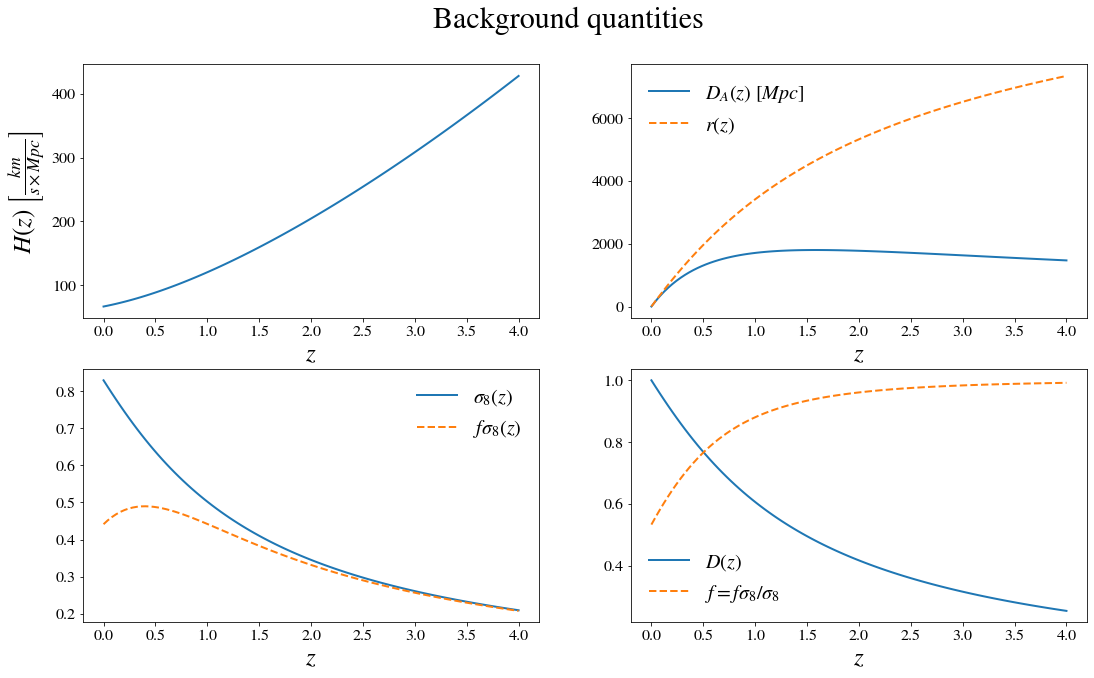

In [21]:
# Let's plot the background quantities of cosmo_dic
# See http://pf-ist-likelihood.pages.euclid-sgs.uk/likelihood-implementation/likelihood.cosmo.cosmology.html
# for extra information

fig, axs = plt.subplots(2, 2, figsize=(18,10))
fig.suptitle('Background quantities')
axs[0, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['H_z_func'](like.cosmo.cosmo_dic['z_win']))
axs[0, 0].set_xlabel(r'$z$')
axs[0, 0].set_ylabel(r'$H(z)$ $\left[ \frac{km}{s\times Mpc}\right]$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['d_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$D_A(z)$ $[Mpc]$')
axs[0, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['r_z_func'](like.cosmo.cosmo_dic['z_win']), '--',
              label = r'$r(z)$')
axs[0, 1].set_xlabel(r'$z$')
axs[0, 1].legend(frameon=False)
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['sigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              label = r'$\sigma_8(z)$')
axs[1, 0].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['fsigma8_z_func'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f\sigma_8(z)$')
axs[1, 0].set_xlabel(r'$z$')
axs[1, 0].legend(frameon=False)
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], like.cosmo.cosmo_dic['D_z_k'],
              label = r'$D(z)$')
axs[1, 1].plot(like.cosmo.cosmo_dic['z_win'], 
               like.cosmo.cosmo_dic['f_z'](like.cosmo.cosmo_dic['z_win']),
              '--', label = r'$f = f\sigma_8/\sigma_8$')
axs[1, 1].set_xlabel(r'$z$');
axs[1, 1].legend(frameon=False)
plt.subplots_adjust(top=0.90)

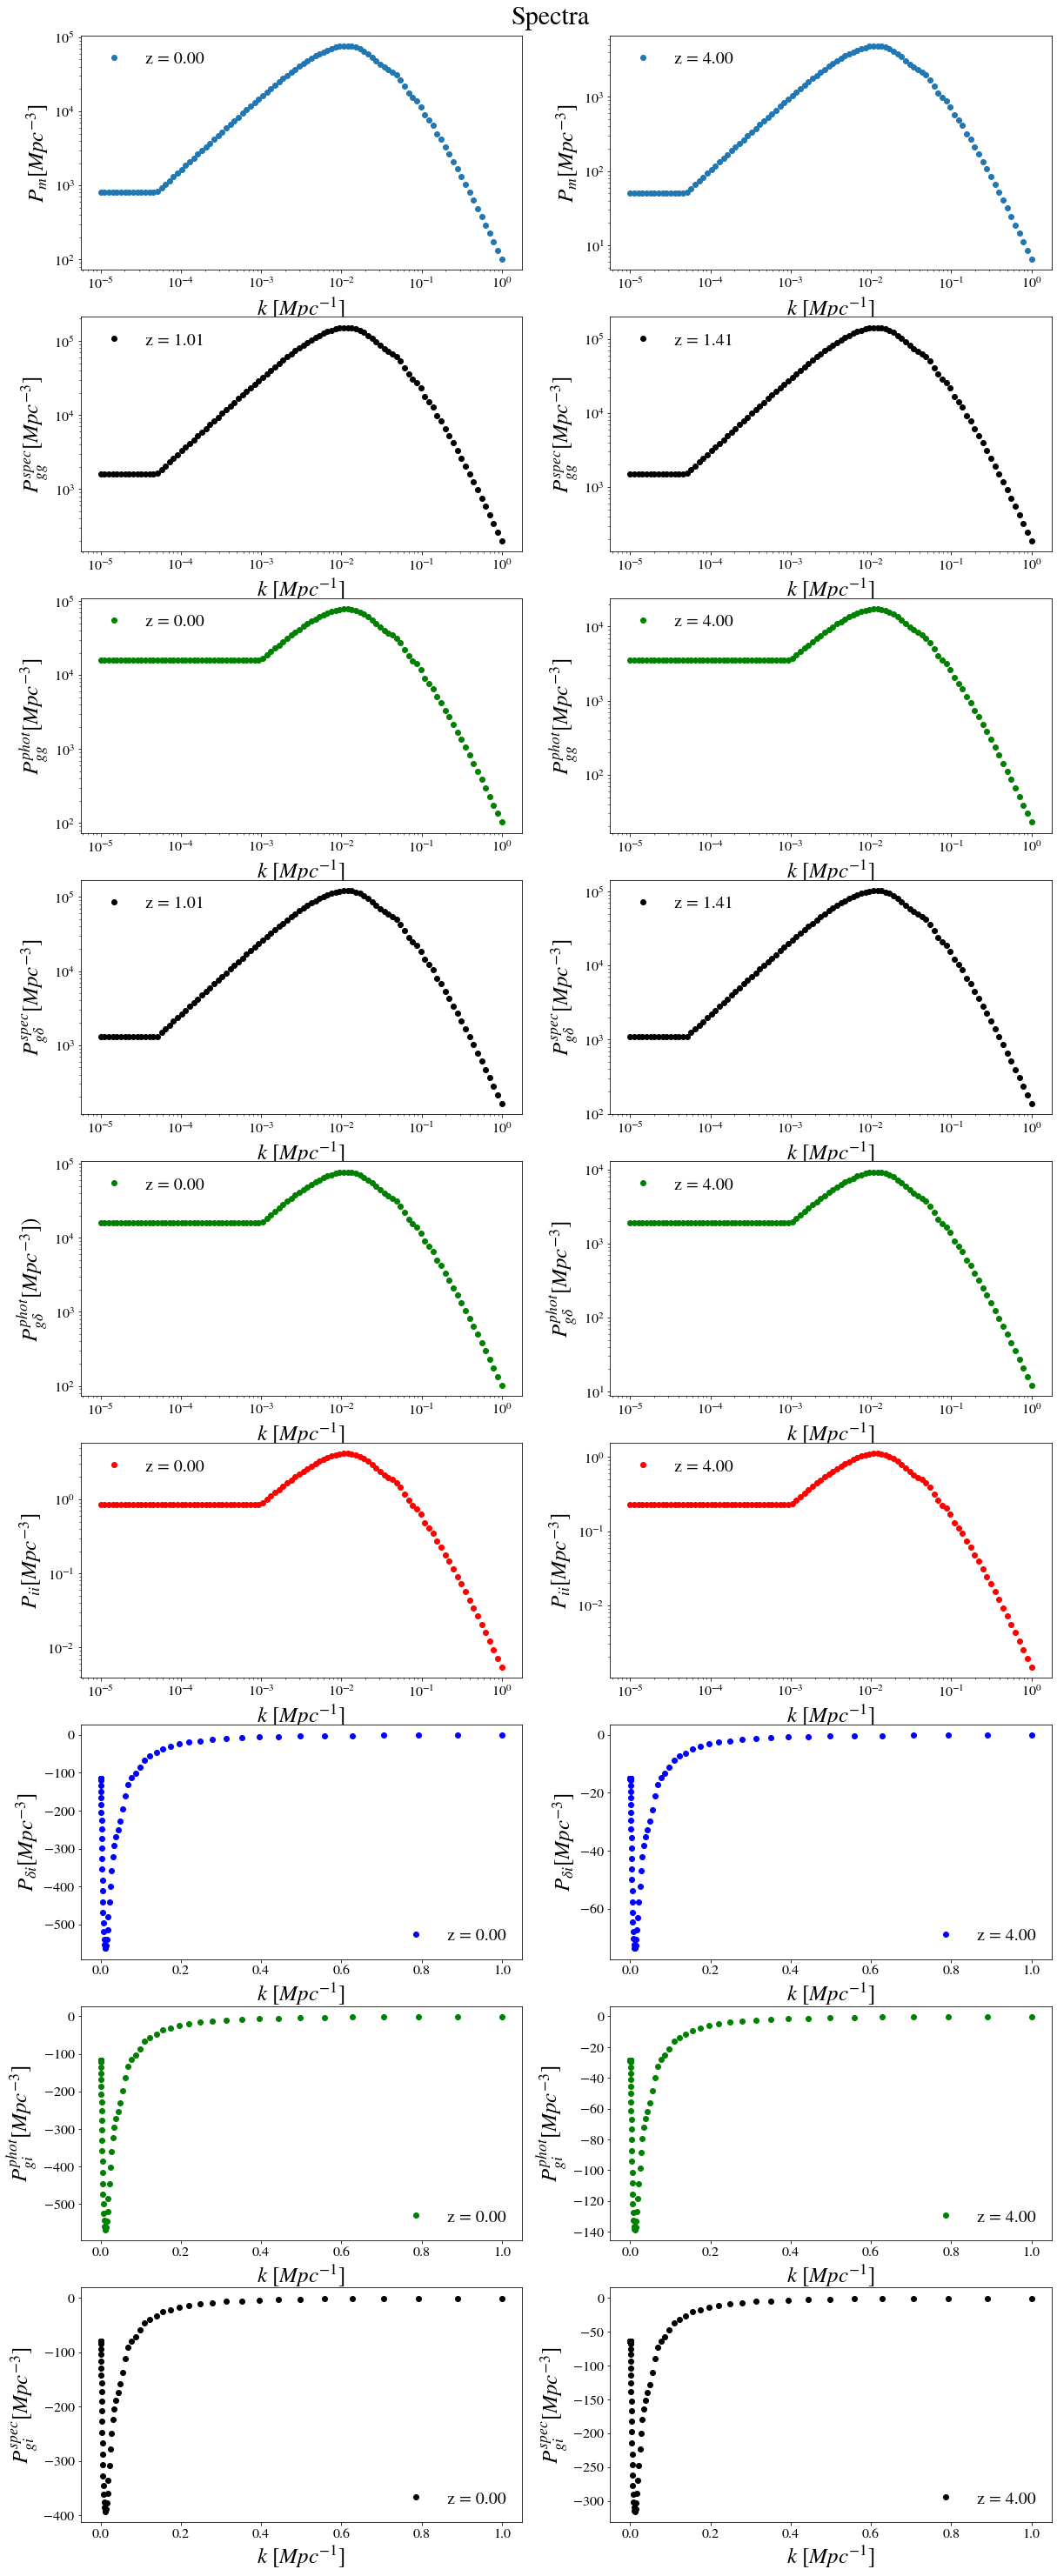

In [22]:
# Let's plot the matter power spectrum and other spectra quantities
# 'Pgg_spec', 'Pgg_phot', 'Pgdelta_phot', 'Pgdelta_spec', 'Pii', 'Pdeltai', 'Pgi_phot', 'Pgi_spec' 
# See http://pf-ist-likelihood.pages.euclid-sgs.uk/likelihood-implementation/likelihood.cosmo.cosmology.html
# for extra information

# WARNING: AT THE MOMENT, THE LARGE SCALES (small k values) in the power spectra are not physical
import warnings
warnings.filterwarnings('ignore')
fig, axs = plt.subplots(9, 2, figsize=(20,47))
fig.suptitle('Spectra')
ks=np.logspace(-5, 0, 100)
axs[0, 0].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][0], ks), 'o', 
           label=r"z = {:.2f}".format(like.cosmo.cosmo_dic['z_win'][0]))
axs[0, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[0, 0].set_ylabel(r'$P_m [Mpc^{-3}]$')
axs[0, 0].legend(frameon=False)
#------
axs[0, 1].loglog(ks, like.cosmo.cosmo_dic['Pk_delta'].P(like.cosmo.cosmo_dic['z_win'][-1], ks), 'o', 
           label=r"z = {:.2f}".format(like.cosmo.cosmo_dic['z_win'][-1]))
axs[0, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[0, 1].set_ylabel(r'$P_m [Mpc^{-3}]$')
axs[0, 1].legend(frameon=False)
#------
for i, k in enumerate(ks):
    axs[1, 0].loglog(k, like.cosmo.cosmo_dic['Pgg_spec'](
    like.cosmo.cosmo_dic['z_win'][25], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][25]) if i == 0 else "")
    axs[1, 1].loglog(k, like.cosmo.cosmo_dic['Pgg_spec'](
    like.cosmo.cosmo_dic['z_win'][35], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][35]) if i == 0 else "")
axs[1, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[1, 0].set_ylabel(r'$P_{gg}^{spec} [Mpc^{-3}]$')
axs[1, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[1, 1].set_ylabel(r'$P_{gg}^{spec} [Mpc^{-3}]$')
axs[1, 0].legend(frameon=False)
axs[1, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[2, 0].loglog(k, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[2, 1].loglog(k, like.cosmo.cosmo_dic['Pgg_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[2, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[2, 0].set_ylabel(r'$P_{gg}^{phot} [Mpc^{-3}]$')
axs[2, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[2, 1].set_ylabel(r'$P_{gg}^{phot} [Mpc^{-3}]$')
axs[2, 0].legend(frameon=False)
axs[2, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[3, 0].loglog(k, like.cosmo.cosmo_dic['Pgdelta_spec'](
    like.cosmo.cosmo_dic['z_win'][25], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][25]) if i == 0 else "")
    axs[3, 1].loglog(k, like.cosmo.cosmo_dic['Pgdelta_spec'](
    like.cosmo.cosmo_dic['z_win'][35], k, 1), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][35]) if i == 0 else "")
axs[3, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[3, 0].set_ylabel(r'$P_{g\delta}^{spec} [Mpc^{-3}]$')
axs[3, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[3, 1].set_ylabel(r'$P_{g\delta}^{spec} [Mpc^{-3}]$')
axs[3, 0].legend(frameon=False)
axs[3, 1].legend(frameon=False)


#------
for i, k in enumerate(ks):
    axs[4, 0].loglog(k, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[4, 1].loglog(k, like.cosmo.cosmo_dic['Pgdelta_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[4, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[4, 0].set_ylabel(r'$P_{g\delta}^{phot} [Mpc^{-3}])$')
axs[4, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[4, 1].set_ylabel(r'$P_{g\delta}^{phot} [Mpc^{-3}]$')
axs[4, 0].legend(frameon=False)
axs[4, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[5, 0].loglog(k, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'ro', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[5, 1].loglog(k, like.cosmo.cosmo_dic['Pii'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'ro', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[5, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[5, 0].set_ylabel(r'$P_{ii} [Mpc^{-3}]$')
axs[5, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[5, 1].set_ylabel(r'$P_{ii} [Mpc^{-3}]$')
axs[5, 0].legend(frameon=False)
axs[5, 1].legend(frameon=False)

#------
for i, k in enumerate(ks):
    axs[6, 0].plot(k, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'bo', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[6, 1].plot(k, like.cosmo.cosmo_dic['Pdeltai'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'bo', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[6, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[6, 0].set_ylabel(r'$P_{\delta i} [Mpc^{-3}]$')
axs[6, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[6, 1].set_ylabel(r'$P_{\delta i} [Mpc^{-3}]$')
axs[6, 0].legend(frameon=False, loc=4)
axs[6, 1].legend(frameon=False, loc=4)

#------
for i, k in enumerate(ks):
    axs[7, 0].plot(k, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[7, 1].plot(k, like.cosmo.cosmo_dic['Pgi_phot'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'go', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[7, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[7, 0].set_ylabel(r'$P_{gi}^{phot} [Mpc^{-3}]$')
axs[7, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[7, 1].set_ylabel(r'$P_{gi}^{phot} [Mpc^{-3}]$')
axs[7, 0].legend(frameon=False, loc=4)
axs[7, 1].legend(frameon=False, loc=4)

#------
for i, k in enumerate(ks):
    axs[8, 0].plot(k, like.cosmo.cosmo_dic['Pgi_spec'](
    like.cosmo.cosmo_dic['z_win'][0], k), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][0]) if i == 0 else "")
    axs[8, 1].plot(k, like.cosmo.cosmo_dic['Pgi_spec'](
    like.cosmo.cosmo_dic['z_win'][-1], k), 'ko', label=r"z = {:.2f}".format(
        like.cosmo.cosmo_dic['z_win'][-1]) if i == 0 else "")
axs[8, 0].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[8, 0].set_ylabel(r'$P_{gi}^{spec} [Mpc^{-3}]$')
axs[8, 1].set_xlabel(r'$k$ $[Mpc^{-1}]$')
axs[8, 1].set_ylabel(r'$P_{gi}^{spec} [Mpc^{-3}]$')
axs[8, 0].legend(frameon=False, loc=4)
axs[8, 1].legend(frameon=False, loc=4)

plt.subplots_adjust(top=0.97)

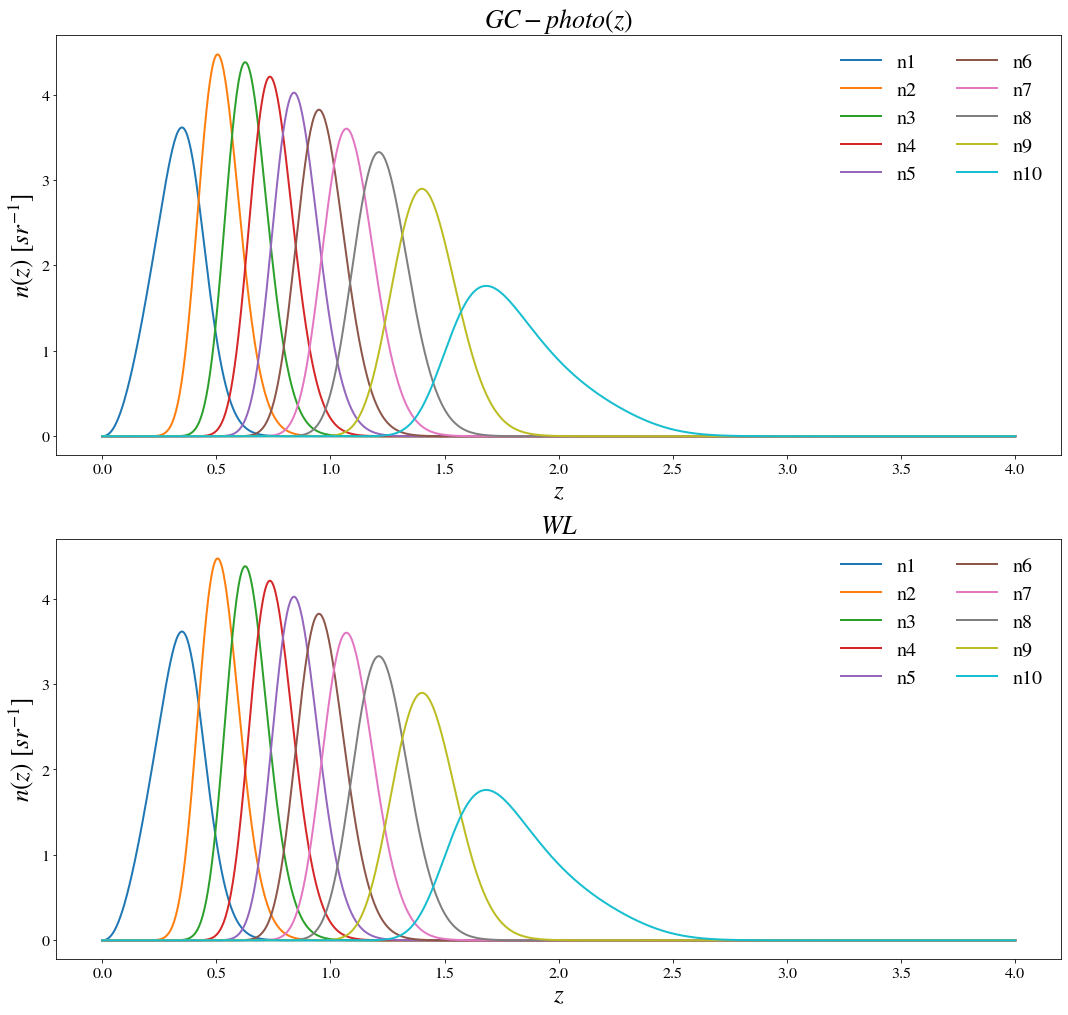

In [23]:
# We can also plot the initial data read by the like_calc module (class Euclike). 
# This data is at the moment the fiducial data store within the data folder of the repository

# i.e: let's plot the galaxy distributions for GC-photo(z) and WL (AT THE MOMENT, THEY ARE THE SAME)
zs = np.linspace(0, 4, 1000)
fig, axs = plt.subplots(2, 1, figsize=(18,17))
for key, value in like.likefinal.data_ins.nz_dict_GC_Phot.items():
    axs[0].plot(zs, value(zs), label = key)
for key, value in like.likefinal.data_ins.nz_dict_WL.items():
    axs[1].plot(zs, value(zs), label = key)
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$n(z)$ $[sr^{-1}]$')
axs[0].set_title(r'$GC-photo(z)$')
axs[0].legend(frameon=False, ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$n(z)$ $[sr^{-1}]$')
axs[1].set_title(r'$WL$')
axs[1].legend(frameon=False, ncol=2);
#plt.subplots_adjust(top=0.90)

In [24]:
# We can also plot the window functions for the photometric observables
# For that, you need to import the photo class and read the cosmology dictionary and the n(z) distributions above
from likelihood.photometric_survey.photo import Photo
photo = Photo(like.cosmo.cosmo_dic, like.likefinal.data_ins.nz_dict_WL, like.likefinal.data_ins.nz_dict_GC_Phot)

bin: 1
bin: 2
bin: 3
bin: 4
bin: 5
bin: 6
bin: 7
bin: 8
bin: 9
bin: 10


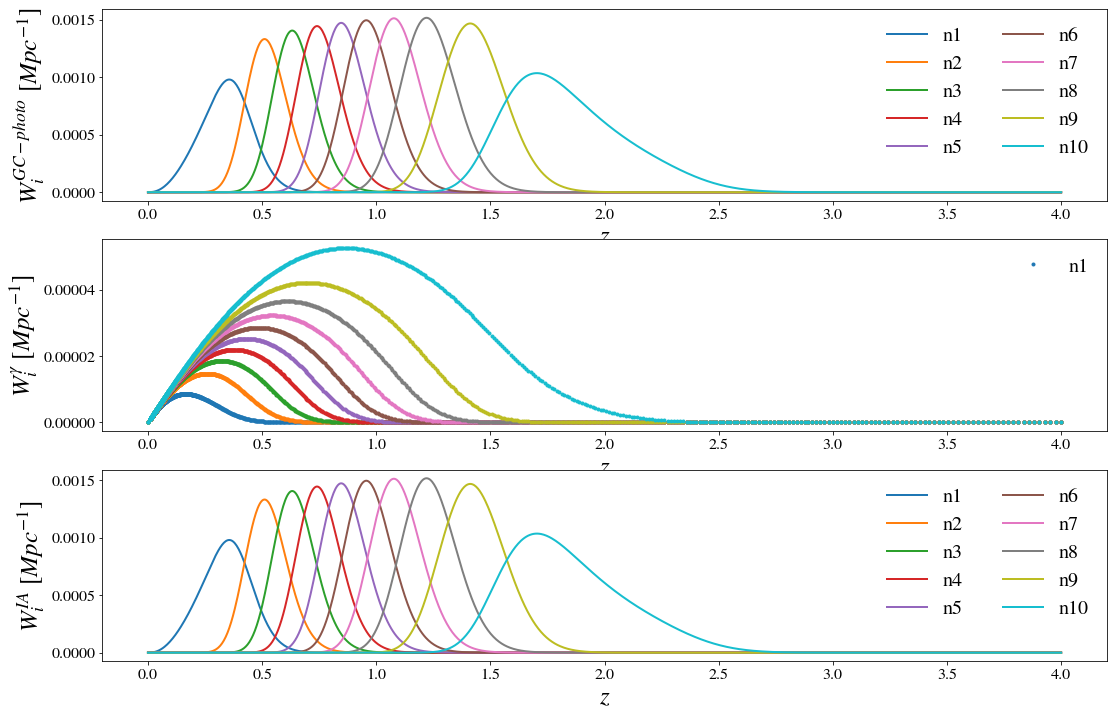

In [25]:
import matplotlib.colors as mcolors
color = list(mcolors.TABLEAU_COLORS.values())
fig, axs = plt.subplots(3, 1, figsize=(18,12))
for i in range(0, 10):
    print('bin: {}'.format(i+1))
    axs[0].plot(zs, photo.GC_window(zs, i+1), '-', label='n{}'.format(i+1))
    axs[1].plot(photo.z_winterp, photo.WL_window(i+1), '.', color = color[i], label='n{}'.format(i+1) if i == 0 else "")
    axs[2].plot(zs, photo.IA_window(zs, i+1), label='n{}'.format(i+1))
axs[0].set_xlabel(r'$z$')
axs[0].set_ylabel(r'$W_i^{GC-photo}$ $[Mpc^{-1}]$')
axs[0].legend(frameon=False, ncol=2)
axs[1].set_xlabel(r'$z$')
axs[1].set_ylabel(r'$W_i^{\gamma}$ $[Mpc^{-1}]$')
axs[1].legend(frameon=False, ncol=2);
axs[2].set_xlabel(r'$z$')
axs[2].set_ylabel(r'$W_i^{IA}$ $[Mpc^{-1}]$')
axs[2].legend(frameon=False, ncol=2);

### Plot Euclid final observables

We can use the auxiliary module of the CLOE to plot the final observables. **Have in mind that the predicted values for the angular power spectra will probably not agree with the fiducial plotted values from the Benchmark data as we are currently sampling $n_s$.**

In [26]:
# We import the Plotter Class
from likelihood.auxiliary.plotter import Plotter

In [27]:
for k in model.parameterization.sampled_params():
    print(k)

ns


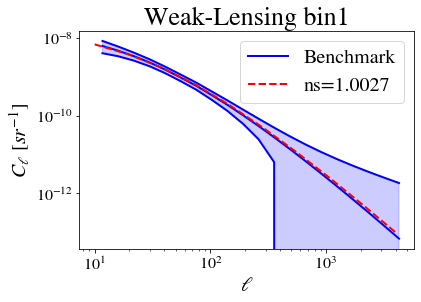

In [28]:
# Weak-Lensing angular power spectrum according to the IST:L recipe 
fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible missmatch between benchmark and theoretical prediction'.format(param))
pl_inst = Plotter(cosmo_dic=like.cosmo.cosmo_dic)
ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='WL', pl_label='Benchmark')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='WL', pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$ $[sr^{-1}]$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('Weak-Lensing bin1');
ax1.legend();

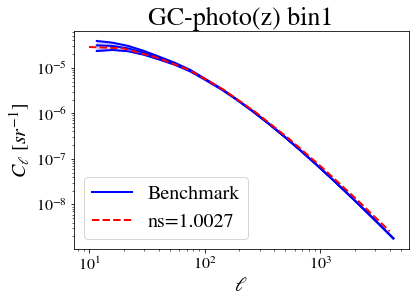

In [29]:
# GC-photo(z) angular power spectrum

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible missmatch between benchmark and theoretical prediction'.format(param))
ax1 = pl_inst.plot_external_Cl_phot(1, 1, ax1, probe='GC-Phot', pl_label='Benchmark')
ax1 = pl_inst.plot_Cl_phot(np.logspace(1, 3.6, 10), 1, 1, ax1, probe='GC-Phot', pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$ $[sr^{-1}]$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('GC-photo(z) bin1');
ax1.legend();

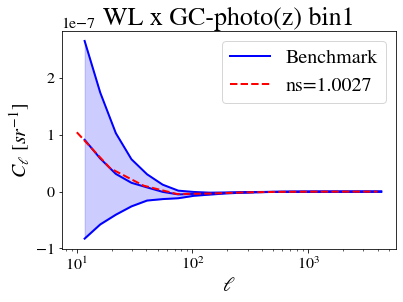

In [30]:
# Cross-correlation WL x GC-photo(z) angular power spectrum

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible missmatch between benchmark and theoretical prediction'.format(param))
ax1 = pl_inst.plot_external_Cl_XC(1, 1, ax1, pl_label='Benchmark')
ax1 = pl_inst.plot_Cl_XC(np.logspace(1, 3.6, 10), 1, 1, ax1, pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$\ell$', fontsize=20)
ax1.set_ylabel(r'$C_\ell$ $[sr^{-1}]$', fontsize=20)
ax1.set_xscale('log')
#ax1.set_yscale('log')
ax1.set_title('WL x GC-photo(z) bin1');
ax1.legend();

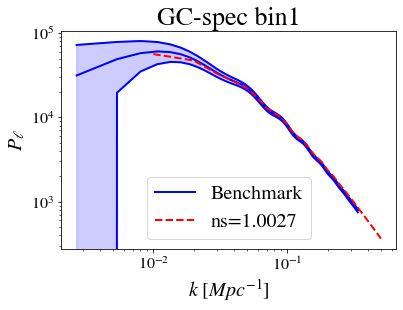

In [31]:
# GC-spec observable

fig1 = plt.figure()
ax1 = fig1.add_subplot(1, 1, 1)
for param in model.parameterization.sampled_params().keys():
        pl_label = '{}={:.4f}'.format(param, model.parameterization.sampled_params()[param])
        print('WARNING: param {} is being sampled! Possible missmatch between benchmark and theoretical prediction'.format(param))
ax1 = pl_inst.plot_external_GC_spec("1.2", 2, ax1, pl_label='Benchmark')
ax1 = pl_inst.plot_GC_spec_multipole(1.2, np.linspace(0.01, 0.5), 2, ax1, pl_colour='r', pl_linestyle='--', pl_label=pl_label)
ax1.set_xlabel(r'$k$ $[Mpc^{-1}]$', fontsize=20)
ax1.set_ylabel(r'$P_\ell$', fontsize=20)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_title('GC-spec bin1');
ax1.legend();